In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import sys,os,glob
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'src')
functionsdir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
sys.path.insert(0,functionsdir)
for includedir in [moduledir,functionsdir]:
    print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                     for x in glob.glob(os.path.join(includedir,'*.py'))])

from conditionalstats import *
from plot1DInvLog import *
from plot2D import *

## Input data dir
inputdir = os.path.join(os.path.dirname(workdir),'input')

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/distributed/utils.py:138: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


Own modules available: ['conditionalstats']
Own modules available: ['plot2D', 'plot1DInvLog']


In [3]:
print("import some 2D variables")
file2D = os.path.join(inputdir,'fplane_n01_300_i03_256.2Dcom_1.nc')
varids2drop = ['SHF', 'LHF', 'LWNS', 'LWNSC', 'LWNT', 'LWNTC', 'SWNS', 'SWNSC', 'SWNT', 'SWNTC', 'IntQN', 'IntQP', 'MSE', 'USFC', 'VSFC', 'W500', 'SWVP', 'TSFC', 'QSFC']
ds_2D = xr.open_dataset(file2D,decode_cf=False,drop_variables=varids2drop)

import some 2D variables


In [4]:
print("import some 3D variables")
file3D = os.path.join(inputdir,'fplane_n01_300_i03_256_0000864000.com3D.alltimes.nc')
varids2drop = ['p', 'U', 'V', 'TABS']
ds_3D = xr.open_dataset(file3D,decode_cf=False,drop_variables=varids2drop)

import some 3D variables


In [5]:
print("pick reference time")
dt_2D = np.diff(ds_2D.time)[0] # days
t_0 = 50 # days
i_t2D = int(t_0/dt_2D)
dt_3D = np.diff(ds_3D.time)[0] # days
i_t3D = int(t_0/dt_3D)

pick reference time


In [6]:
print("compute distribution of reference variable")
ref_varid = 'PW'
verbose = False
# Initialize
ref_dist_linear = Distribution(name=ref_varid)
# Compute
ref_dist_linear.computeDistribution(sample=ds_2D[ref_varid][i_t2D].values)
# Compute locations of reference bins
ref_dist_linear.storeSamplePoints(sample=ds_2D[ref_varid][i_t2D].values,verbose=verbose)

compute distribution of reference variable


In [7]:
print('check size')
ref_dist_linear.nlb, ref_dist_linear.nbins

check size


(50, 50)

In [8]:
print("compute conditional distribution for a 2D variable")
verbose = True
cond_varid_2D = 'Prec'
# Initialize
cond_dist_2D = ConditionalDistribution(name=cond_varid_2D,
                                       is3D=False,
                                       on=ref_dist_linear)
# Compute conditional distributions
cond_dist_2D.computeConditionalMeanAndVariance(sample=ds_2D[cond_varid_2D][i_t2D].values,
                                               verbose=False)


compute conditional distribution for a 2D variable


showing conditional distribution of 2D variable


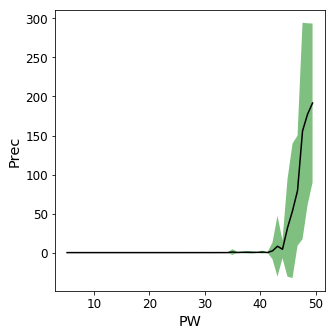


# INCLUDE SUBPLOT FUNCTION INSIDE CONDITIONALDISTRIBUTION OBJECT
# ADD attributes self.cond_std, self.cond_Q1, self.cond_med, self.cond_Q3 for interquartile range



In [9]:
print("showing conditional distribution of 2D variable")
fig,ax = plt.subplots(figsize=(5,5))
# plot mean
ax.plot(cond_dist_2D.on.percentiles,cond_dist_2D.cond_mean,'k')
# plot 1-sigma standard error
x = cond_dist_2D.on.percentiles
y1 = cond_dist_2D.cond_mean - np.sqrt(cond_dist_2D.cond_var)
y2 = cond_dist_2D.cond_mean + np.sqrt(cond_dist_2D.cond_var)
ax.fill_between(x,y1,y2,where=y2>=y1,facecolor='g',alpha=0.5,interpolate=True)

ax.set_xlabel(ref_varid)
ax.set_ylabel(cond_varid_2D)

plt.show()
print("""
# INCLUDE SUBPLOT FUNCTION INSIDE CONDITIONALDISTRIBUTION OBJECT
# ADD attributes self.cond_std, self.cond_Q1, self.cond_med, self.cond_Q3 for interquartile range
""")

In [10]:
ds_3D

<xarray.Dataset>
Dimensions:  (time: 100, x: 256, y: 256, z: 53)
Coordinates:
  * x        (x) float32 0.0 4000.0 8000.0 ... 1012000.0 1016000.0 1020000.0
  * y        (y) float32 0.0 4000.0 8000.0 ... 1012000.0 1016000.0 1020000.0
  * z        (z) float32 37.5 118.59 212.84 322.3 ... 17348.28 17765.27 18194.28
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 ... 96.0 97.0 98.0 99.0 100.0
Data variables:
    W        (time, z, y, x) float32 ...
    QRAD     (time, z, y, x) float32 ...
    QV       (time, z, y, x) float32 ...
    QN       (time, z, y, x) float32 ...
    QP       (time, z, y, x) float32 ...
Attributes:
    history:                   Wed Nov 16 15:29:34 2016: ncrcat fplane_n01_30...
    nco_openmp_thread_number:  1

In [11]:
print("compute conditional distribution for a 3D variable")
# cond_varid_3D = 'W'
cond_varid_3D = 'QRAD'
# Initialize
cond_dist_3D = ConditionalDistribution(name=cond_varid_3D,
                                       is3D=True,
                                       on=ref_dist_linear)
# Compute conditional distributions
cond_dist_3D.computeConditionalMeanAndVariance(ds_3D[cond_varid_3D][i_t3D].values)


compute conditional distribution for a 3D variable


showing conditional distribution of 2D variable


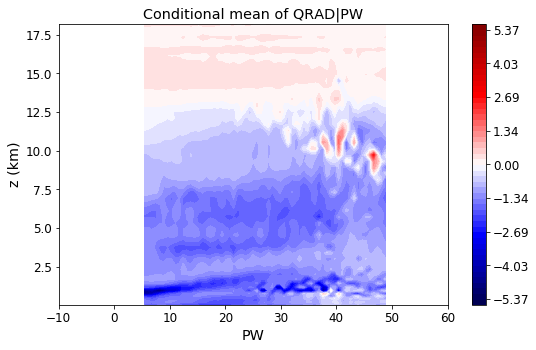

In [12]:
print("showing conditional distribution of 2D variable")

## Plot parameters
x = cond_dist_3D.on.percentiles
y = ds_3D.z/1000
Z = cond_dist_3D.cond_mean
vmax = max(abs(np.max(Z)),abs(np.min(Z)))
vmin = -vmax

## Plot
fig,ax = plt.subplots(figsize=(9,5))
h = subplotSmooth2D(ax,x,\
                  y,\
                  Z,\
               fplot='contourf',\
               xmin=-10,xmax=60,nx=100,\
               vmin=vmin,vmax=vmax,\
               cmap = plt.cm.seismic)
ax.set_xlabel(ref_varid)
ax.set_ylabel('z (km)')
ax.set_title('Conditional mean of %s|%s'%(cond_varid_3D,ref_varid))

plt.colorbar(h)

plt.show()

showing conditional distribution of 2D variable


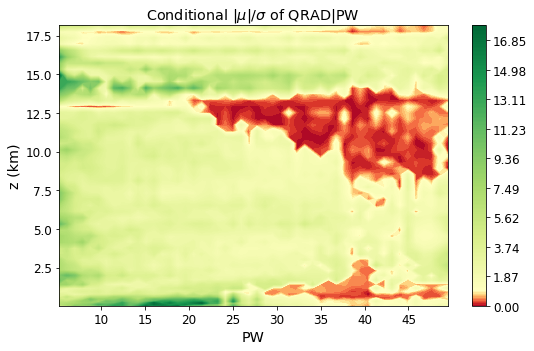

In [15]:
print("showing conditional distribution of 2D variable")

## Plot parameters
x = cond_dist_3D.on.percentiles
y = ds_3D.z/1000
Z = np.absolute(cond_dist_3D.cond_mean)/cond_dist_3D.cond_std
vmax = max(abs(np.max(Z)),abs(np.min(Z)))
vmin = 0

norm = MidpointNormalize(midpoint=1,vmin=vmin,vmax=vmax)

## Plot
fig,ax = plt.subplots(figsize=(9,5))
h = subplotSmooth2D(ax,x,\
                  y,\
                  Z,\
               fplot='contourf',\
#                xmin=10,xmax=40,nx=100,\
               vmin=vmin,vmax=vmax,nlev=200,\
               cmap = plt.cm.RdYlGn,\
               norm=norm)
ax.set_xlabel(ref_varid)
ax.set_ylabel('z (km)')
ax.set_title('Conditional $|\mu|/\sigma$ of %s|%s'%(cond_varid_3D,ref_varid))

plt.colorbar(h)

plt.show()

In green where signal-to-noise is greater than 1, in red where it is below 1